In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

try:
  from torchvision import summary
except:
  print("[INFO] Couldn't finf torchinfo...installing!!")
  !pip install torchinfo
  from torchinfo import summary

!pip install torchmetrics

[INFO] Couldn't finf torchinfo...installing!!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_data = datasets.Flowers102(root="data", split='train', download=True, transform=auto_transforms)
val_data = datasets.Flowers102(root="data", split='val', download=True, transform=auto_transforms)
test_data = datasets.Flowers102(root="data", split='test', download=True, transform=auto_transforms)

In [ ]:
train_dataset = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataset = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
for params in model.features.parameters():
  params.requires_grad = False

In [ ]:
output_shape = 102

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 102]            --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

model = model.to(device)
epochs = 10

epoch_count = []
train_loss_values = []
train_acc_values = []
val_loss_values = []
val_acc_values = []
test_loss_values = []
tes_loss_values = []
test_acc_values = []

for epoch in range(epochs):
  model.train()
  train_loss = 0
  train_accuracy = MulticlassAccuracy(num_classes=102).to(device)

  for (X, y) in train_dataset:
    X = X.to(device)
    y = y.long().to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    train_accuracy.update(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss/len(train_dataset)
  train_acc = train_accuracy.compute().item()

  model.eval()
  val_loss = 0
  val_accuracy = MulticlassAccuracy(num_classes=102).to(device)
  with torch.inference_mode():
    for val_X, val_y in val_dataset:
      val_X = val_X.to(device)
      val_y = val_y.long().to(device)

      val_pred = model(val_X)
      val_loss_cal = loss_fn(val_pred, val_y)
      val_loss += val_loss_cal.item()

      val_accuracy.update(val_pred, val_y)

  val_loss = val_loss/len(val_dataset)
  val_acc = val_accuracy.compute().item()


  test_loss = 0
  test_accuracy = MulticlassAccuracy(num_classes=102).to(device)

  with torch.inference_mode():
    for test_X, test_y in test_dataset:
      test_X = test_X.to(device)
      test_y = test_y.long().to(device)

      test_pred = model(test_X)
      test_loss_cal = loss_fn(test_pred, test_y)
      test_loss += test_loss_cal.item()

      test_accuracy.update(test_pred, test_y)

  test_loss = test_loss/len(test_dataset)
  test_acc = test_accuracy.compute().item()

  epoch_count.append(epoch)
  train_loss_values.append(train_loss)
  train_acc_values.append(train_acc)
  val_loss_values.append(val_loss)
  val_acc_values.append(val_acc)
  test_loss_values.append(test_loss)
  test_acc_values.append(test_acc)

  print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")




Epoch: 1 | Train Loss: 4.3066 | Train Acc: 0.1529 | Val Loss: 3.4962 | Val Acc: 0.5529 | Test Loss: 3.5162 | Test Acc: 0.5520
Epoch: 2 | Train Loss: 2.8167 | Train Acc: 0.8059 | Val Loss: 2.6011 | Val Acc: 0.7529 | Test Loss: 2.6538 | Test Acc: 0.7491
Epoch: 3 | Train Loss: 1.8406 | Train Acc: 0.9333 | Val Loss: 2.0336 | Val Acc: 0.7863 | Test Loss: 2.1128 | Test Acc: 0.7979
Epoch: 4 | Train Loss: 1.2647 | Train Acc: 0.9608 | Val Loss: 1.6644 | Val Acc: 0.8225 | Test Loss: 1.7490 | Test Acc: 0.8205
Epoch: 5 | Train Loss: 0.8990 | Train Acc: 0.9794 | Val Loss: 1.4348 | Val Acc: 0.8431 | Test Loss: 1.5225 | Test Acc: 0.8300
Epoch: 6 | Train Loss: 0.6784 | Train Acc: 0.9873 | Val Loss: 1.2804 | Val Acc: 0.8480 | Test Loss: 1.3605 | Test Acc: 0.8418
Epoch: 7 | Train Loss: 0.5272 | Train Acc: 0.9922 | Val Loss: 1.1599 | Val Acc: 0.8520 | Test Loss: 1.2388 | Test Acc: 0.8440
Epoch: 8 | Train Loss: 0.4164 | Train Acc: 0.9922 | Val Loss: 1.0752 | Val Acc: 0.8647 | Test Loss: 1.1591 | Test Acc:

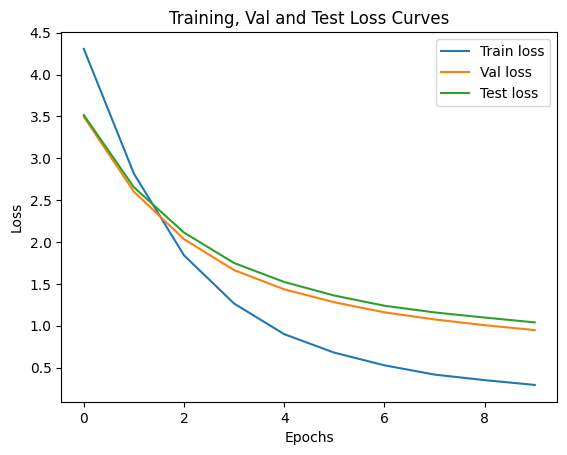

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_loss_np = torch.tensor(train_loss_values).cpu().numpy()
val_loss_np = torch.tensor(val_loss_values).cpu().numpy()
test_loss_np = torch.tensor(test_loss_values).cpu().numpy()

plt.plot(epoch_count, train_loss_np, label="Train loss")
plt.plot(epoch_count, val_loss_np, label="Val loss")
plt.plot(epoch_count, test_loss_np, label="Test loss")
plt.title("Training, Val and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

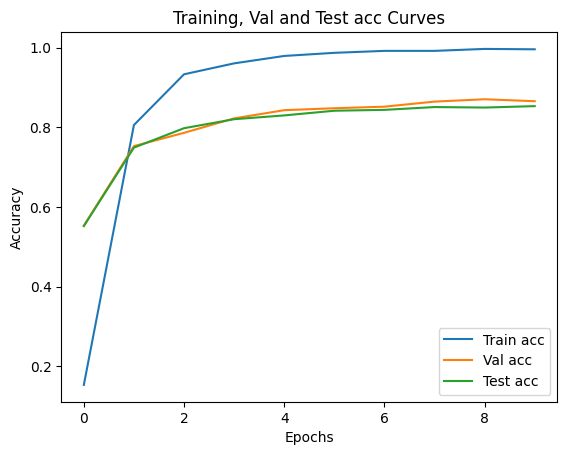

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_acc_np = torch.tensor(train_acc_values).cpu().numpy()
val_acc_np = torch.tensor(val_acc_values).cpu().numpy()
test_acc_np = torch.tensor(test_acc_values).cpu().numpy()

plt.plot(epoch_count, train_acc_np, label="Train acc")
plt.plot(epoch_count, val_acc_np, label="Val acc")
plt.plot(epoch_count, test_acc_np, label="Test acc")
plt.title("Training, Val and Test acc Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from PIL import Image

img = Image.open("/content/test9.png")

if img.mode == "RGBA":
  img = img.convert("RGB")

In [ ]:
new_img_tensor = auto_transforms(img).unsqueeze(0).to(device)

In [ ]:
with torch.inference_mode():
  output = model(new_img_tensor)
  pred = torch.argmax(output, dim=1).item()

flower_classes = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise',
    'monkshood', 'globe thistle', 'snapdragon', 'colt\'s foot',
    'king protea', 'spear thistle', 'yellow iris', 'globe-flower',
    'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger',
    'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian',
    'artichoke', 'sweet william', 'carnation', 'garden phlox',
    'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
    'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia',
    'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
    'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy',
    'primula', 'sunflower', 'pelargonium', 'bishop of llandaff',
    'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush',
    'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris',
    'windflower', 'tree poppy', 'gazania', 'azalea',
    'water lily', 'rose', 'thorn apple', 'morning glory',
    'passion flower', 'lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine',
    'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
    'watercress', 'canna lily', 'hippeastrum', 'bee balm',
    'ball moss', 'foxglove', 'bougainvillea', 'camellia',
    'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose'
]


print(f"predicted class: {pred} -> {flower_classes[pred]}")


predicted class: 82 -> hibiscus
